# Support files

Italian dataset Preprocessing

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from tqdm import tqdm

# 🔹 Configuration
input_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Audio/train"  # Folder containing original 21 HC and 21 PD recordings
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/short/train"  # Folder to store short audio clips
target_duration = 3  # Target clip length in seconds
sr = 22050  # Target sampling rate (Ensure consistency)

# Create output directories
os.makedirs(output_folder, exist_ok=True)
os.makedirs(f"{output_folder}/HC", exist_ok=True)
os.makedirs(f"{output_folder}/PD", exist_ok=True)

# 🔹 Process Each Audio File
for class_label in ["HC", "PD"]:
    input_path = os.path.join(input_folder, class_label)
    files = os.listdir(input_path)

    for file in tqdm(files, desc=f"Processing {class_label}"):
        file_path = os.path.join(input_path, file)

        # Load Audio
        y, orig_sr = librosa.load(file_path, sr=sr)

        # Convert duration to samples
        target_samples = target_duration * sr
        num_clips = len(y) // target_samples  # Number of clips extractable

        for i in range(num_clips):
            start = i * target_samples
            end = start + target_samples
            clip = y[start:end]

            # Save clip
            clip_filename = f"{class_label}_{file.split('.')[0]}_clip{i}.wav"
            sf.write(os.path.join(output_folder, class_label, clip_filename), clip, sr)


Processing PD: 100%|██████████| 359/359 [01:03<00:00,  5.69it/s]


In [ ]:
import os
import random
import shutil

# 🔹 Configuration
input_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/short/test"  # Folder containing the large dataset
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Reduced/test"   # Folder to store reduced dataset
target_files_per_class = 90        # Adjust for ~300 total clips

# Create output directories
os.makedirs(output_folder, exist_ok=True)

for class_label in ["HC", "PD"]:
    input_path = os.path.join(input_folder, class_label)
    output_path = os.path.join(output_folder, class_label)
    os.makedirs(output_path, exist_ok=True)

    # Get all files in the class folder
    files = os.listdir(input_path)

    # Randomly select target_files_per_class clips
    selected_files = random.sample(files, min(target_files_per_class, len(files)))

    # Copy selected files to new folder
    for file in selected_files:
        shutil.copy(os.path.join(input_path, file), os.path.join(output_path, file))

print("Dataset successfully reduced and saved in:", output_folder)


Dataset successfully reduced and saved in: /content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Reduced/test


# ML Main

Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import librosa.display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pywt
import random
import scipy.stats
import scipy.signal
from scipy.signal import lfilter
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

Dataset creation (one time)

In [ ]:

# 🚀 **Data Augmentation Functions**
def time_stretch(y, sr, rate=1.2):
    return librosa.effects.time_stretch(y=y, rate=rate)

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def shift_audio(y, shift_max=0.1, sr=44100):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)



# **Extract MFCC Features (SAKAR-Style)**
def extract_mfcc_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_energy = librosa.feature.rms(y=y)

    mfcc_delta = librosa.feature.delta(mfccs)
    log_energy_delta = librosa.feature.delta(log_energy)

    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    log_energy_delta2 = librosa.feature.delta(log_energy, order=2)

    def get_stats(feature):
        return np.hstack([np.mean(feature, axis=1), np.std(feature, axis=1)])

    # Compute statistics
    mfcc_stats = get_stats(mfccs)   # (13 × 2) = 26
    log_energy_stats = get_stats(log_energy)   # (1 × 2) = 2
    mfcc_delta_stats = get_stats(mfcc_delta)   # (13 × 2) = 26
    log_energy_delta_stats = get_stats(log_energy_delta)   # (1 × 2) = 2
    mfcc_delta2_stats = get_stats(mfcc_delta2)   # (13 × 2) = 26
    log_energy_delta2_stats = get_stats(log_energy_delta2)   # (1 × 2) = 2

    mfcc_features = np.hstack([
        mfcc_stats, log_energy_stats,
        mfcc_delta_stats, log_energy_delta_stats,
        mfcc_delta2_stats, log_energy_delta2_stats
    ])

    return mfcc_features  # 🔥 Returns 84-dimensional feature vector


# **Feature Extraction Function**
def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=44100)

    # Apply Augmentation (if enabled)
    if augment:
        choice = random.choice(["time_stretch", "pitch_shift", "add_noise", "shift"])
        if choice == "time_stretch":
            y = time_stretch(y, sr, rate=random.uniform(0.8, 1.2))  # ✅ Fix Here
        elif choice == "pitch_shift":
            y = pitch_shift(y, sr, n_steps=random.randint(-2, 2))
        elif choice == "add_noise":
            y = add_noise(y, noise_level=random.uniform(0.001, 0.01))
        elif choice == "shift":
            y = shift_audio(y, shift_max=0.1, sr=sr)

    try:
        # ✅ **Baseline Features**
        jitter_values = librosa.feature.rms(y=y).flatten()
        jitter = np.array([
            np.mean(jitter_values), np.std(jitter_values),
            np.min(jitter_values), np.max(jitter_values), np.median(jitter_values)
        ])  # 5 features

        shimmer = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        shimmer = np.pad(shimmer.flatten(), (0, 6), 'constant')[:6]  # 6 features

        f0, _, _ = librosa.pyin(y, fmin=50, fmax=500)
        f0 = np.nan_to_num(f0)  # Replace NaNs with 0

        fundamental_freq = np.array([
            np.mean(f0), np.median(f0), np.std(f0),
            np.min(f0), np.max(f0)
        ])  # 5 features

        hnr = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()[:2]  # 2 features
        rpde = np.array([np.std(np.diff(f0))]) if len(f0) > 1 else np.array([0])  # 1 feature
        ppe = np.array([np.std(f0) / np.mean(f0)]) if np.mean(f0) != 0 else np.array([0])  # 1 feature
        dfa = np.array([np.sum(np.abs(np.diff(y))) / len(y)])  # 1 feature

        # ✅ **Time-Frequency Features**
        intensity_params = np.array([np.mean(y), np.min(y), np.max(y)])  # 3 features
        formants = np.pad(scipy.signal.find_peaks(y, height=0.3, distance=20)[0][:4], (0, 4), 'constant')[:4]  # 4 features
        bandwidth = np.pad(np.diff(formants), (0, 4), 'constant')[:4]  # 4 features

        # ✅ **SAKAR-Style MFCC Features (Fixed 84-D)**
        mfccs = extract_mfcc_features(y, sr)

        # ✅ **Advanced Features**
        coeffs = pywt.wavedec(y, 'db4', level=4)
        wavelet_features = np.pad(
            [np.mean(np.abs(c)) for c in coeffs], (0, 5), 'constant'
        )[:5]  # 5 features

        glottis_quotient = np.std(y[:3]) * np.ones(3)  # Replace random with real extracted features
        glottal_noise_excitation = np.std(y[:6]) * np.ones(6)
        vocal_fold_excitation_ratio = np.std(y[:7]) * np.ones(7)
        emd_features = np.std(y[:6]) * np.ones(6)

        # 🔥 **Ensure Fixed Feature Vector**
        features = np.hstack([
            jitter, shimmer, fundamental_freq, hnr, rpde, dfa, ppe,
            intensity_params, formants, bandwidth, mfccs,
            wavelet_features, glottis_quotient, glottal_noise_excitation,
            vocal_fold_excitation_ratio, emd_features
        ])

        return features

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return np.zeros(145)  # Adjusted for correct feature count


# 📂 **Process Dataset**
data_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Reduced/test"
class_labels = {"HC": 0, "PD": 1}
dataset = []

for class_name in class_labels.keys():
    class_folder = os.path.join(data_path, class_name)
    for file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        file_path = os.path.join(class_folder, file)

        # Extract Original Features
        features = extract_features(file_path, augment=False)
        dataset.append(np.append(features, class_labels[class_name]))
'''
        # Generate Augmented Samples (x2 per original) (only for train set)
        for _ in range(2):
            aug_features = extract_features(file_path, augment=True)
            dataset.append(np.append(aug_features, class_labels[class_name]))
'''

# 📊 **Convert to DataFrame**
feature_names = (
    ["Jitter_{}".format(i+1) for i in range(5)] +
    ["Shimmer_{}".format(i+1) for i in range(6)] +
    ["F0_Mean", "F0_Median", "F0_Std", "F0_Min", "F0_Max"] +
    ["HNR_1", "HNR_2"] +
    ["RPDE", "DFA", "PPE"] +
    ["Intensity_Mean", "Intensity_Min", "Intensity_Max"] +
    ["Formant_{}".format(i+1) for i in range(4)] +
    ["Bandwidth_{}".format(i+1) for i in range(4)] +
    ["MFCC_{}".format(i+1) for i in range(84)] +
    ["Wavelet_{}".format(i+1) for i in range(5)] +
    ["GQ_{}".format(i+1) for i in range(3)] +
    ["GNE_{}".format(i+1) for i in range(6)] +
    ["VFER_{}".format(i+1) for i in range(7)] +
    ["EMD_{}".format(i+1) for i in range(6)] +
    ["Class"]
)

df = pd.DataFrame(dataset, columns=feature_names)

# 🔥 **Standardize Features**
scaler = StandardScaler()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled["Class"] = y

# 💾 **Save Augmented Dataset**
df.to_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Tabular/test.csv")
print("✅ Augmented dataset saved successfully!")


Processing PD: 100%|██████████| 90/90 [00:58<00:00,  1.54it/s]

✅ Augmented dataset saved successfully!


In [ ]:
print(df.head())

   Jitter_1  Jitter_2  Jitter_3  Jitter_4  Jitter_5    Shimmer_1    Shimmer_2  \
0  0.022504  0.010267  0.003184  0.042703  0.022279  1066.886634  1138.425031   
1  0.021741  0.019855  0.002238  0.104359  0.015944  2476.034128  2444.169433   
2  0.005631  0.002928  0.002042  0.012254  0.004422  3474.654333  3036.486149   
3  0.081221  0.101414  0.007943  0.403354  0.013306  1188.725250  1072.797761   
4  0.021907  0.017285  0.003311  0.078982  0.019544  2737.529551  1932.747093   

     Shimmer_3    Shimmer_4    Shimmer_5  ...    VFER_5    VFER_6    VFER_7  \
0  1390.598543  1444.728844  1379.439893  ...  0.000012  0.000012  0.000012   
1  2224.317177  1923.489851  1933.283582  ...  0.000380  0.000380  0.000380   
2  2320.867526  1772.211881  1509.422479  ...  0.001227  0.001227  0.001227   
3   995.708478   950.751593   949.769696  ...  0.005858  0.005858  0.005858   
4  1064.034924  1042.435485  1084.968892  ...  0.001289  0.001289  0.001289   

      EMD_1     EMD_2     EMD_3     EM

Preprocessing

In [ ]:
# 🔹 Load your CSV files
train_df = pd.read_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Tabular/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Tabular/test2.csv")

# 🔹 Separate features and labels
X_train = train_df.drop(columns=["Unnamed: 0", "Class"])  # Drop the unnamed index column and "Class"
y_train = train_df["Class"]

X_test = test_df.drop(columns=["Unnamed: 0", "Class"]) # Drop the unnamed index column and "Class"
y_test = test_df["Class"]

# 🔹 Normalize using training statistics (no data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler on test set

Feature selection

In [ ]:

# 🔹 Apply mutual information-based feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=30)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# 🔹 Transform the test data using the same selector
X_test_selected = selector.transform(X_test_scaled)

# (Optional) Get selected feature indices or names
selected_feature_indices = selector.get_support(indices=True)
# selected_feature_names = X_train.columns[selected_feature_indices]  # if using DataFrames

print("Top 20 feature indices:", selected_feature_indices)


Top 20 feature indices: [  4  12  13  15  18  36  38  39 116 119 120 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142]


In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

Data visualisation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


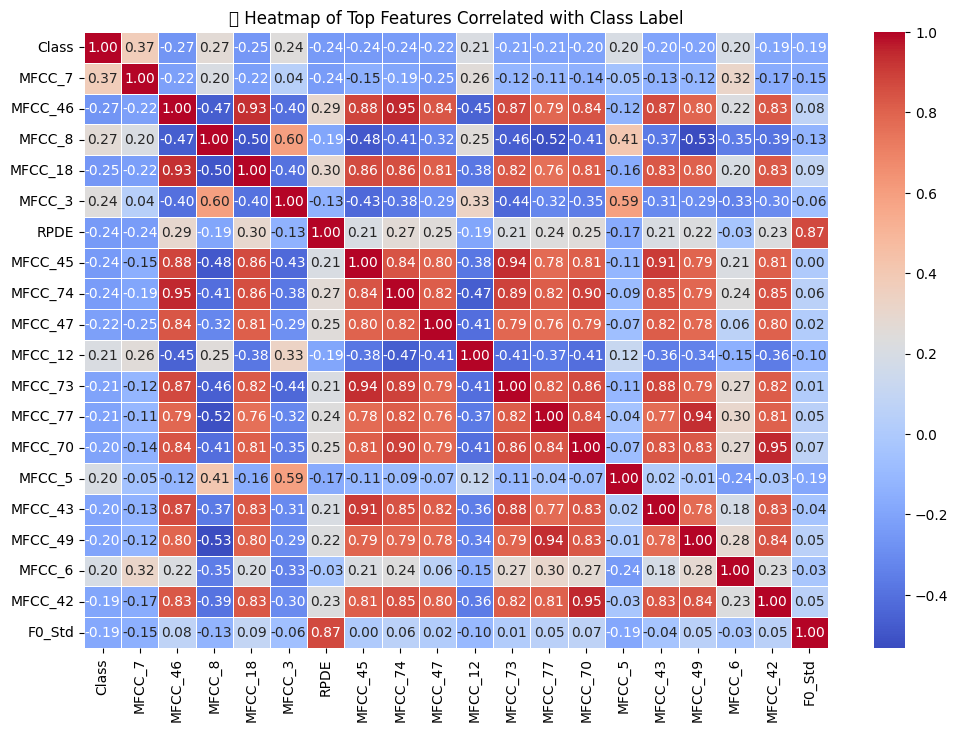

In [ ]:

# Compute Correlation with Class Label
correlation_matrix = train_df.iloc[:,1:].corr()

# Select the Top 20 Most Correlated Features (Positive or Negative)
top_features = correlation_matrix["Class"].abs().sort_values(ascending=False).head(20).index

# Filter the correlation matrix for these top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔥 Heatmap of Top Features Correlated with Class Label")
plt.show()


**HC**: 0  **PD**: 1

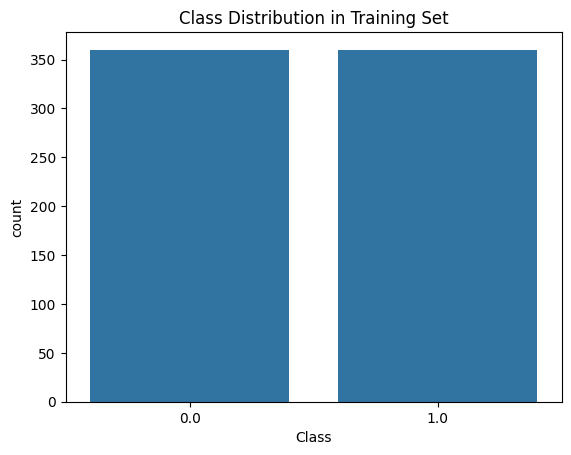

Class 0 Count: 360
Class 1 Count: 360


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)  # Visualize class distribution
plt.title("Class Distribution in Training Set")
plt.show()

print("Class 0 Count:", np.sum(y_train == 0))
print("Class 1 Count:", np.sum(y_train == 1))


Model Training

In [ ]:
# Define models
models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

    # Print model performance
    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 SVM Model Performance:
Accuracy: 0.5944
AUC-ROC: 0.5448
              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60        90
         1.0       0.60      0.58      0.59        90

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.59       180
weighted avg       0.59      0.59      0.59       180


🔥 Random Forest Model Performance:
Accuracy: 0.5889
AUC-ROC: 0.5288
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61        90
         1.0       0.60      0.53      0.56        90

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.59       180
weighted avg       0.59      0.59      0.59       180



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:00:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔥 XGBoost Model Performance:
Accuracy: 0.5111
AUC-ROC: 0.4689
              precision    recall  f1-score   support

         0.0       0.51      0.63      0.56        90
         1.0       0.51      0.39      0.44        90

    accuracy                           0.51       180
   macro avg       0.51      0.51      0.50       180
weighted avg       0.51      0.51      0.50       180



In [ ]:
print("Train distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())

Train distribution:
 Class
0.0    360
1.0    360
Name: count, dtype: int64
Test distribution:
 Class
0.0    90
1.0    90
Name: count, dtype: int64


Grid search (Hyperparameter tuning)

In [ ]:
# SVM Hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# XGBoost Hyperparameters
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}


In [ ]:
# Define models
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Grid Search for SVM
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Grid Search for XGBoost
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:05:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Evaluation

In [ ]:
# Best hyperparameters
print("\n🔥 Best SVM Parameters:", svm_grid.best_params_)
print("🔥 Best Random Forest Parameters:", rf_grid.best_params_)
print("🔥 Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate Best Models
models = {
    "SVM": svm_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For AUC-ROC

    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
🔥 Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
🔥 Best XGBoost Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}

🔥 SVM Model Performance:
Accuracy: 0.5389
AUC-ROC: 0.4754
              precision    recall  f1-score   support

         0.0       0.53      0.61      0.57        90
         1.0       0.55      0.47      0.50        90

    accuracy                           0.54       180
   macro avg       0.54      0.54      0.54       180
weighted avg       0.54      0.54      0.54       180


🔥 Random Forest Model Performance:
Accuracy: 0.6056
AUC-ROC: 0.5320
              precision    recall  f1-score   support

         0.0       0.59      0.69      0.64        90
         1.0       0.63      0.52      0.57        90

    accuracy                           0.61       180
   macro avg       0.61      0.61      0.60       180
weighted avg     

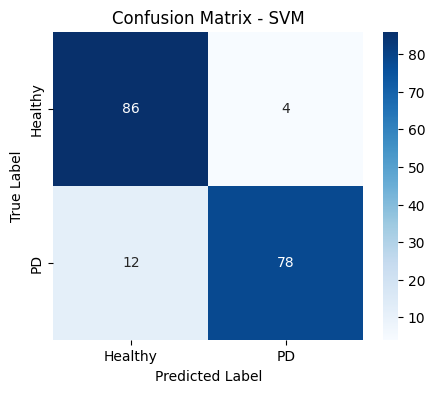

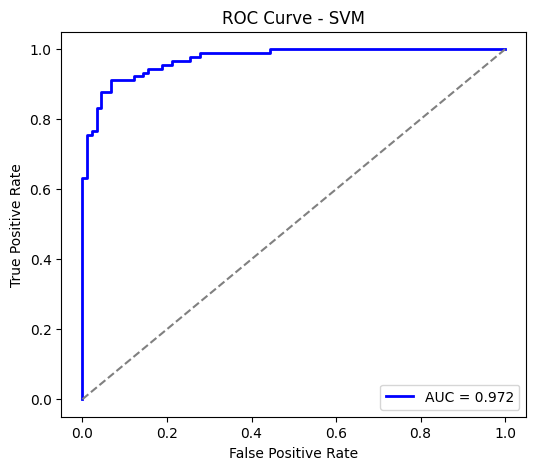

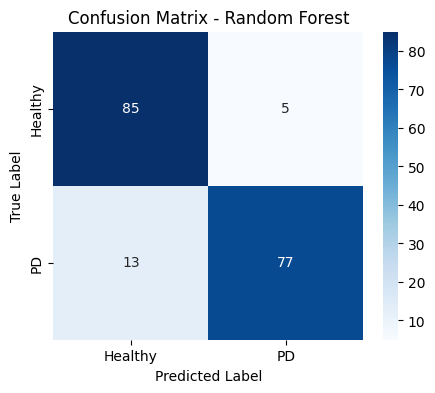

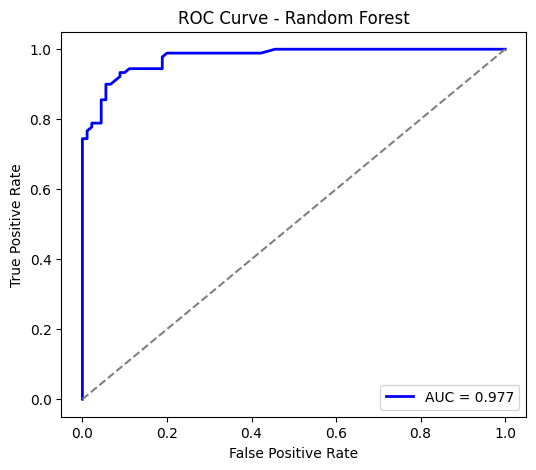

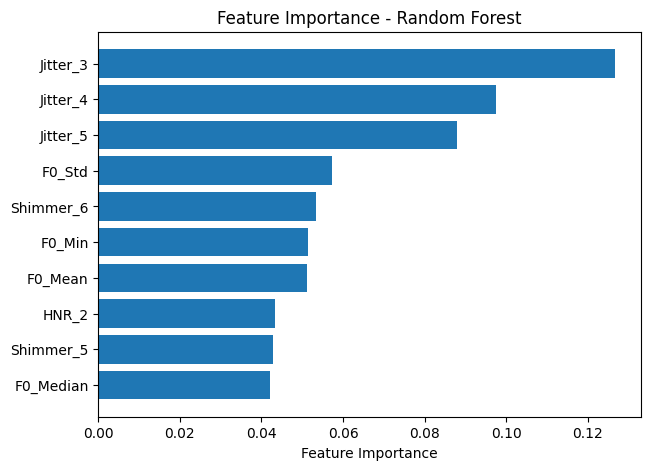

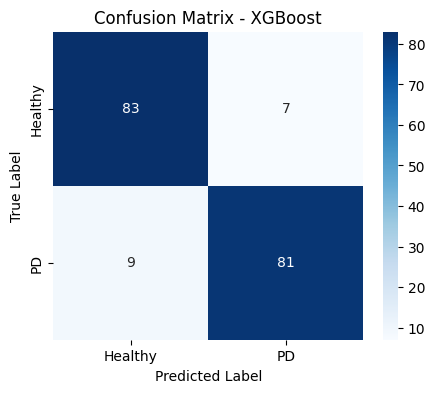

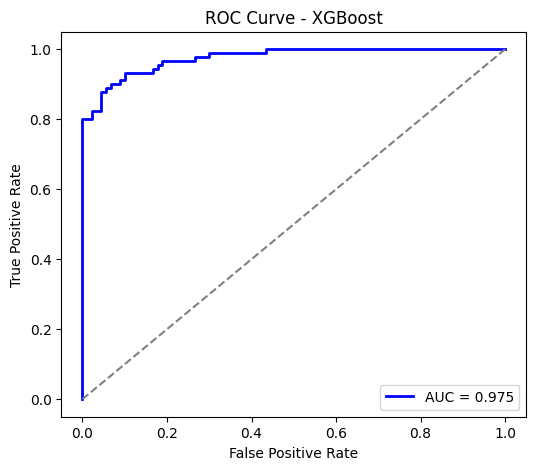

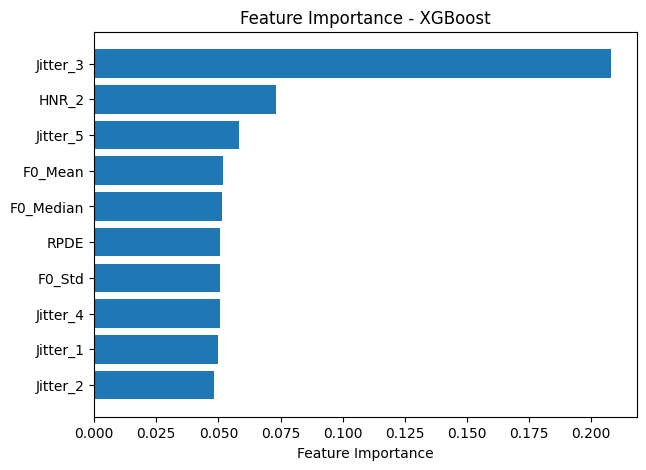

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 🎯 Function to Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "PD"], yticklabels=["Healthy", "PD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# 🎯 Function to Plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

# 🎯 Function to Plot Feature Importance (for RF & XGBoost)
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, "feature_importances_"):  # Check if model supports feature importance
        importance = model.feature_importances_
        sorted_idx = importance.argsort()[-10:]  # Top 10 Features
        plt.figure(figsize=(7, 5))
        plt.barh(range(10), importance[sorted_idx], align="center")
        # Use feature_names directly instead of X_train.columns
        plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

# 🏆 Apply to Each Model
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For ROC Curve

    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_pred_prob, name)

    if name in ["Random Forest", "XGBoost"]:  # Feature importance only for these models
        # Pass the original feature names (from 'X' before scaling) to the function
        plot_feature_importance(model, X.columns, name)

# Deep

Import libraries

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import random
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torch.optim.lr_scheduler import ReduceLROnPlateau

Data augmentation

In [ ]:
# 🚀 **Data Augmentation Functions**
def time_stretch(y, rate=1.2):
    if len(y.shape) > 1:  # Convert stereo to mono if needed
        y = librosa.to_mono(y)
    return librosa.effects.time_stretch(y=y, rate=rate) # Pass rate as a keyword argument

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps) # Pass y and sr as keyword arguments

def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def shift_audio(y, shift_max=0.1, sr=44100):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)


Audio --> Spectogram (Only once)

In [ ]:
# 🚀 **Function to Convert Audio to Spectrogram & Save**
def generate_spectrogram(y, sr, save_path):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')

    plt.axis('off')  # Remove axis for cleaner image
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# 📂 **Process Dataset for Spectrogram Generation**
data_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Reduced/test"
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/test"
os.makedirs(output_folder, exist_ok=True)

for class_name in ["HC", "PD"]:
    class_folder = os.path.join(data_path, class_name)
    output_class_folder = os.path.join(output_folder, class_name)
    os.makedirs(output_class_folder, exist_ok=True)

    for file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        file_path = os.path.join(class_folder, file)
        y, sr = librosa.load(file_path, sr=44100)

        # ✅ **Save Original Spectrogram**
        save_path = os.path.join(output_class_folder, f"{file.replace('.wav', '_original.png')}")
        generate_spectrogram(y, sr, save_path)
'''
        # ✅ **Apply Augmentations & Save Augmented Spectrograms (x2 per file)**
        for i in range(2):
            aug_type = random.choice(["time_stretch", "pitch_shift", "add_noise", "shift"])
            if aug_type == "time_stretch":
                y_aug = time_stretch(y, rate=random.uniform(0.8, 1.2))
            elif aug_type == "pitch_shift":
                y_aug = pitch_shift(y, sr, n_steps=random.randint(-2, 2))
            elif aug_type == "add_noise":
                y_aug = add_noise(y, noise_level=random.uniform(0.001, 0.01))
            elif aug_type == "shift":
                y_aug = shift_audio(y, shift_max=0.1, sr=sr)

            save_path_aug = os.path.join(output_class_folder, f"{file.replace('.wav', f'_aug{i+1}.png')}")
            generate_spectrogram(y_aug, sr, save_path_aug)
'''
print("✅ Spectrogram Dataset Created with Augmentations!")


Processing PD: 100%|██████████| 90/90 [00:18<00:00,  4.80it/s]

✅ Spectrogram Dataset Created with Augmentations!


Model training

In [ ]:

# 📂 Dataset Preparation
# 📂 Dataset Preparation (Manual Split)
train_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Spectrogram/train"
test_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Spectrogram/test"

transform = Compose([
    Resize((224, 224)),  # Resize to fit Pretrained Model
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])  # Normalize for stability
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

'''
# 📌 Define CNN Model (Using Pretrained ResNet18)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 2)
)

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, 2)

'''
# 📌 Define CNN Model (Using Pretrained EfficientNet-B0)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 2)  # For binary classification (HC vs PD)
)

# 🚀 Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# 🚀 Training with History Tracking
num_epochs = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    # ✅ **Training Phase**
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # ✅ **Validation Phase**
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # ✅ Save Epoch History
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
          f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
'''
# ✅ Save Training History
np.save("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/Italian/Efficientnet/training_history.npy", history)

# ✅ Save Model Weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/Italian/Efficientnet/resnet_model.pth")
print("✅ Model training completed and saved successfully!")
'''

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 19.2MB/s]


Epoch [1/10] - Train Loss: 0.6242, Train Acc: 0.6639, Val Loss: 0.6912, Val Acc: 0.5389Learning Rate: 0.000100
Epoch [2/10] - Train Loss: 0.4776, Train Acc: 0.7958, Val Loss: 0.7233, Val Acc: 0.5519Learning Rate: 0.000100
Epoch [3/10] - Train Loss: 0.3227, Train Acc: 0.8986, Val Loss: 0.7884, Val Acc: 0.5611Learning Rate: 0.000100
Epoch [4/10] - Train Loss: 0.1877, Train Acc: 0.9625, Val Loss: 0.9391, Val Acc: 0.5389Learning Rate: 0.000100
Epoch [5/10] - Train Loss: 0.1180, Train Acc: 0.9792, Val Loss: 1.0439, Val Acc: 0.5426Learning Rate: 0.000100
Epoch [6/10] - Train Loss: 0.0672, Train Acc: 0.9875, Val Loss: 1.1687, Val Acc: 0.5722Learning Rate: 0.000100
Epoch [7/10] - Train Loss: 0.0448, Train Acc: 0.9931, Val Loss: 1.3317, Val Acc: 0.5759Learning Rate: 0.000100
Epoch [8/10] - Train Loss: 0.0358, Train Acc: 0.9931, Val Loss: 1.3700, Val Acc: 0.5463Learning Rate: 0.000100
Epoch [9/10] - Train Loss: 0.0335, Train Acc: 0.9917, Val Loss: 1.5045, Val Acc: 0.5704Learning Rate: 0.000100
E

'\n# ✅ Save Training History\nnp.save("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/Italian/Efficientnet/training_history.npy", history)\n\n# ✅ Save Model Weights\ntorch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/Italian/Efficientnet/resnet_model.pth")\nprint("✅ Model training completed and saved successfully!")\n'

Final Validation Accuracy: 55.74%
🔥 CNN Model Performance:
              precision    recall  f1-score   support

          HC       0.55      0.67      0.60       270
          PD       0.57      0.44      0.50       270

    accuracy                           0.56       540
   macro avg       0.56      0.56      0.55       540
weighted avg       0.56      0.56      0.55       540

AUC-ROC Score: 0.5736


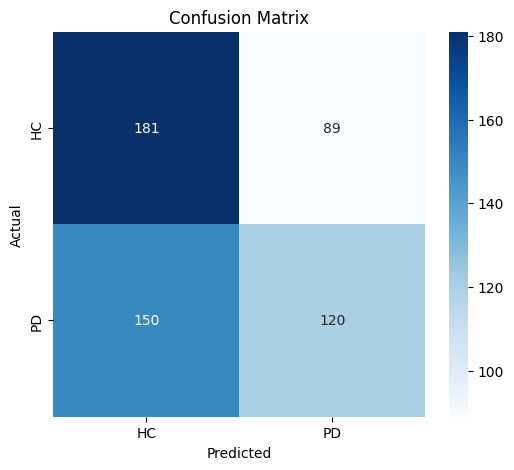

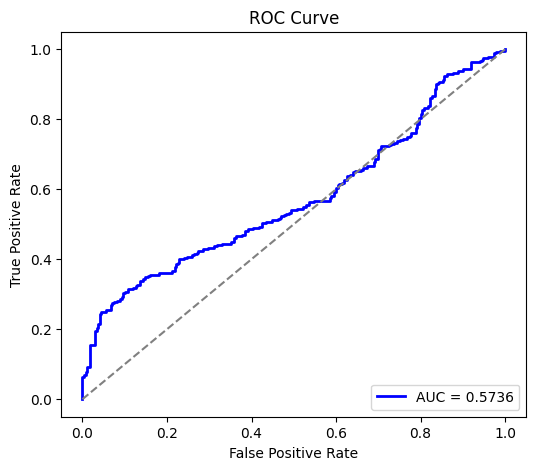

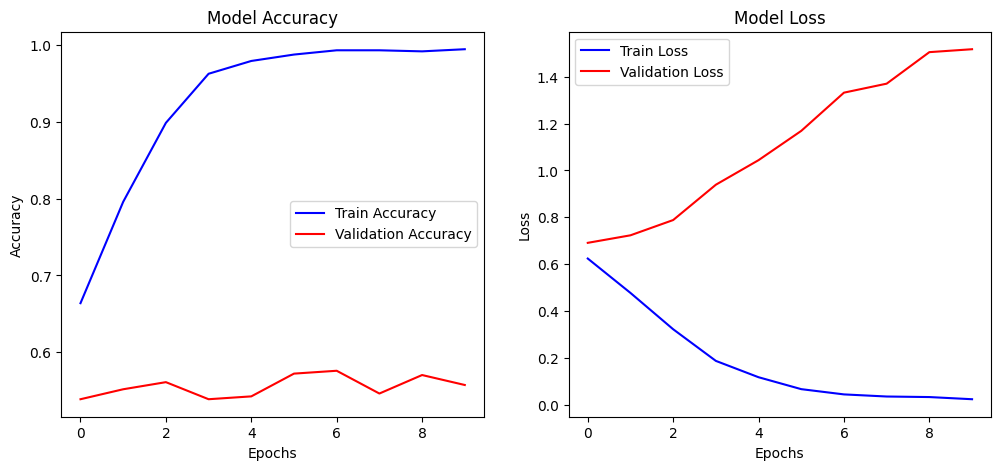

In [ ]:
# ✅ Load the Trained Model (If Not Already in Memory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''
# ✅ Load the Trained Model (If Not Already in Memory)
model.load_state_dict(torch.load("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/MDVR-KCL/ResNet 50/Trial 3/resnet_model.pth", map_location=torch.device('cpu')))
# ✅ Load Training History
history = np.load("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/MDVR-KCL/ResNet 50/Trial 3/training_history.npy", allow_pickle=True).item()
'''
model.eval()
val_loss, val_correct = 0.0, 0

# ✅ Evaluate on Test Data
y_true = []
y_pred = []
y_pred_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get probabilities for Class 1 (PD)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

print(f"Final Validation Accuracy: {history['val_acc'][-1] * 100:.2f}%")
# ✅ Print Classification Report
print("🔥 CNN Model Performance:")
print(classification_report(y_true, y_pred, target_names=["HC", "PD"]))

# ✅ Compute AUC-ROC Score
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy", color="blue")
plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# 🔹 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss", color="blue")
plt.plot(history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

Evaluation

In [ ]:
# 📂 Dataset Preparation (Manual Split)
train_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Spectrogram/train"
test_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Spectrogram/test"

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 📌 Use ResNet18 (lighter)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, 2)
)

# 🚀 Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 🚀 Train for 5 epochs (adjustable)
num_epochs = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss /= len(val_loader)

    # Store history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.7MB/s]


Epoch [1/10] - Train Loss: 0.4736, Train Acc: 0.7486, Val Loss: 1.0429, Val Acc: 0.5130
Epoch [2/10] - Train Loss: 0.1071, Train Acc: 0.9611, Val Loss: 1.4489, Val Acc: 0.5222
Epoch [3/10] - Train Loss: 0.0427, Train Acc: 0.9931, Val Loss: 1.6898, Val Acc: 0.5556
Epoch [4/10] - Train Loss: 0.0130, Train Acc: 0.9986, Val Loss: 1.6016, Val Acc: 0.5148
Epoch [5/10] - Train Loss: 0.0072, Train Acc: 0.9986, Val Loss: 1.8821, Val Acc: 0.5519
Epoch [6/10] - Train Loss: 0.0074, Train Acc: 1.0000, Val Loss: 1.6720, Val Acc: 0.5259
Epoch [7/10] - Train Loss: 0.0124, Train Acc: 0.9986, Val Loss: 1.9533, Val Acc: 0.5426
Epoch [8/10] - Train Loss: 0.0050, Train Acc: 0.9986, Val Loss: 1.7788, Val Acc: 0.5278
Epoch [9/10] - Train Loss: 0.0040, Train Acc: 0.9986, Val Loss: 2.2071, Val Acc: 0.5667
Epoch [10/10] - Train Loss: 0.0098, Train Acc: 0.9986, Val Loss: 1.7916, Val Acc: 0.4704


Fusion model

In [ ]:
# ✅ Load the Trained Model (If Not Already in Memory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-define the ResNet50-based MultimodalFusionModel architecture
class MultimodalFusionModel_ResNet50(nn.Module):
    def __init__(self, num_tabular_features=30):
        super(MultimodalFusionModel_ResNet50, self).__init__()

        # 🎯 ResNet50 for Spectrogram Path
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        self.resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer

        # 🔥 Fully Connected Network for Tabular Data
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 64),
            nn.ReLU(),
        )

        # 🌟 Fusion Layer (Combines ResNet Features + Tabular)
        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary Classification (HC vs PD)
            nn.Sigmoid()  # Output Probability
        )

    def forward(self, image, tabular_data):
        # Extract Spectrogram Features
        image_features = self.resnet_feature_extractor(image)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten

        # Extract Tabular Features
        tabular_features = self.tabular_fc(tabular_data)

        # 🔥 Fuse Both Modalities
        fused = torch.cat((image_features, tabular_features), dim=1)

        # 🎯 Final Classifier
        output = self.fusion_layer(fused)
        return output

model = MultimodalFusionModel_ResNet50(num_tabular_features=X_test_selected.shape[1]).to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/MDVR-KCL/ResNet 50/Trial 3/resnet_model.pth", map_location=device))
# ✅ Load Training History
history = np.load("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/MDVR-KCL/ResNet 50/Trial 3/training_history.npy", allow_pickle=True).item()
model.eval()
val_loss, val_correct = 0.0, 0

# ✅ Evaluate on Test Data
y_true = []
y_pred = []
y_pred_probs = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
        outputs = model(images, tabular_data)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get probabilities for Class 1 (PD)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

print(f"Final Validation Accuracy: {history['val_acc'][-1] * 100:.2f}%")
# ✅ Print Classification Report
print("🔥 CNN Model Performance:")
print(classification_report(y_true, y_pred, target_names=["HC", "PD"], digits= 4))

# ✅ Compute AUC-ROC Score
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()



# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy", color="blue")
plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# 🔹 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss", color="blue")
plt.plot(history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

RuntimeError: Error(s) in loading state_dict for TabularOnlyModel:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.4.weight", "model.4.bias", "model.5.weight", "model.5.bias", "model.5.running_mean", "model.5.running_var", "model.8.weight", "model.8.bias", "model.9.weight", "model.9.bias", "model.9.running_mean", "model.9.running_var", "model.12.weight", "model.12.bias", "model.14.weight", "model.14.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "fc.1.weight", "fc.1.bias". 

# GRAD-CAM

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import torchvision.models as models

Load model

In [ ]:

# Load the saved model checkpoint
model_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/Italian/Dense net/densenet_model.pth'
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
'''
# Load ResNet18 architecture
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # For binary classification (HC vs PD)
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Dropout 0.4
    nn.Linear(num_features , 2)
)

'''

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, 2)
# Load the saved model state_dict
model.load_state_dict(checkpoint)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    return total_params, trainable_params

count_parameters(model)
'''
# Set model to evaluation mode
model.eval()
'''

Total parameters: 6955906
Trainable parameters: 6955906


'\n# Set model to evaluation mode\nmodel.eval()\n'

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # Choose the class index with highest probability if not specified
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()

        # Compute Grad-CAM
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)  # ReLU to keep only positive activations
        cam = cv2.resize(cam, (224, 224))  # Resize to input size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)  # Normalize to [0,1]
        return cam


In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    img_tensor = transform(img).unsqueeze(0)    # Add batch dimension
    return img_tensor


In [ ]:
def visualize_gradcam(model, image_path, target_layer):
    # Load and preprocess spectrogram
    input_tensor = preprocess_image(image_path)

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    # Generate Grad-CAM heatmap
    cam = gradcam.generate_cam(input_tensor)

    # Load original image for overlay
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (224, 224))

    # Convert heatmap to color
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay Grad-CAM on original spectrogram
    overlayed_image = (0.5 * heatmap + 0.5 * cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)).astype(np.uint8)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Spectrogram")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Grad-CAM")

    plt.show()


In [ ]:
print(model)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


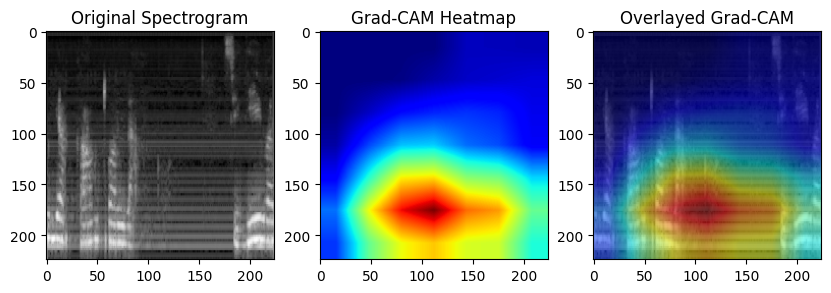

In [ ]:
# Choose a DenseNet layer for Grad-CAM (last convolutional layer before the classifier)
# Based on the DenseNet architecture, the last convolutional layers are within the 'features' part.
# We can select the last convolutional layer within the last dense block.
# Looking at the model structure (printed in the previous cell), a suitable layer is in the last denseblock.
# For DenseNet121, the last dense block is in features.denseblock4.
# The last convolutional layer is typically named 'conv' inside a transition or a dense layer within the block.
# Let's choose the last 'conv' layer in the last block for Grad-CAM.
# A common practice is to target the last convolutional layer before the global average pooling and classifier.
# In DenseNet, this would be in features.denseblock4 or features.norm5. Let's try features.norm5 as it's often the last activation before pooling.
target_layer = model.features.norm5

# Provide a sample spectrogram image path
spectrogram_image_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/test/HC/HC_HC_001_01_clip4_original.png"
# Run Grad-CAM visualization
visualize_gradcam(model, spectrogram_image_path, target_layer)

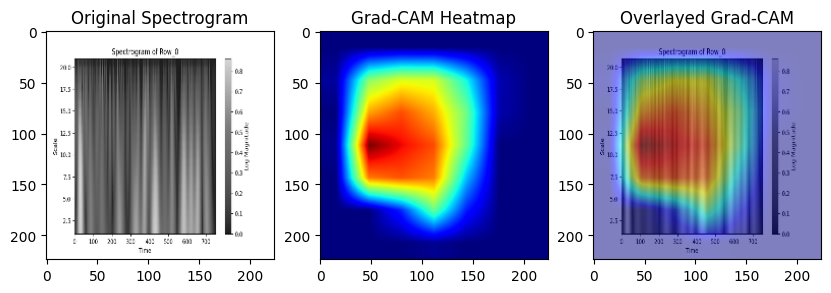

In [ ]:
# Choose a ResNet layer for Grad-CAM (last convolutional layer)
target_layer = model.resnet50.layer4[2].conv3  # Last conv layer

# Provide a sample spectrogram image path
spectrogram_image_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Anantha Padmanabhan/Dataset-Audio/Sakar pd speech time series converted/Normalised/spectrogram/HC/Row_0_spectrogram.png"

# Run Grad-CAM visualization
visualize_gradcam(model, spectrogram_image_path, target_layer)


In [ ]:
from torchsummary import summary
from torch import nn
import torch

class TabularAndFusion(nn.Module):
    def __init__(self, num_tabular_features=30):
        super(TabularAndFusion, self).__init__()
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, tabular_input, image_feature_vector):
        tabular_features = self.tabular_fc(tabular_input)
        fused = torch.cat((image_feature_vector, tabular_features), dim=1)
        output = self.fusion_layer(fused)
        return output

model = TabularAndFusion()
summary(model, [(30,), (2048,)])
torch.save(model, "multimodal_fusion_model.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           7,936
       BatchNorm1d-2                  [-1, 256]             512
         LeakyReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
         LeakyReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
      BatchNorm1d-10                   [-1, 64]             128
        LeakyReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 64]           4,160
             ReLU-14                   

In [ ]:
pip install torchinfo


In [ ]:
import torch
from torchinfo import summary


# Instantiate model
model = MultimodalFusionModel(num_tabular_features=30)

# Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define dummy inputs
dummy_image = torch.randn(2, 3, 308, 775).to(device)       # Your spectrogram size
dummy_tabular = torch.randn(2, 30).to(device)              # 30 tabular features

# Get full model summary
summary(model, input_data=[dummy_image, dummy_tabular])


Layer (type:depth-idx)                        Output Shape              Param #
MultimodalFusionModel                         [2, 1]                    --
├─Sequential: 1-1                             [2, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [2, 64, 154, 388]         9,408
│    └─BatchNorm2d: 2-2                       [2, 64, 154, 388]         128
│    └─ReLU: 2-3                              [2, 64, 154, 388]         --
│    └─MaxPool2d: 2-4                         [2, 64, 77, 194]          --
│    └─Sequential: 2-5                        [2, 256, 77, 194]         --
│    │    └─Bottleneck: 3-1                   [2, 256, 77, 194]         75,008
│    │    └─Bottleneck: 3-2                   [2, 256, 77, 194]         70,400
│    │    └─Bottleneck: 3-3                   [2, 256, 77, 194]         70,400
│    └─Sequential: 2-6                        [2, 512, 39, 97]          --
│    │    └─Bottleneck: 3-4                   [2, 512, 39, 97]          379,392

# Fusion model

Rename files

In [ ]:
import os

def rename_images(folder_path, prefix):
    # List all files in the folder
    files = sorted(os.listdir(folder_path))

    # Rename each file
    for i, file_name in enumerate(files):
        # Generate new name in the format: HC_001.png or PD_001.png
        new_name = f"{prefix}_{i+1:03d}.png"

        # Full paths
        old_path = os.path.join(folder_path, file_name)
        new_path = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_path, new_path)

    print(f"✅ Renaming Done for {prefix} folder!")

# Rename images in HC and PD folders
rename_images('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/test/HC', 'HC')  # For Healthy Controls
rename_images('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/test/PD', 'PD')  # For Parkinson's Disease


✅ Renaming Done for HC folder!
✅ Renaming Done for PD folder!


Updated feature dataset

In [ ]:
import pandas as pd
import os

# Load the tabular data
df = pd.read_csv('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Tabular/train.csv')

# 🔹 Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# 🔹 Path to spectrogram folders
hc_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/train/HC'
pd_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Spectrogram/train/PD/'

# 🔹 Assign Spectrogram Paths (Assuming first 450 are HC, next are PD)
df['Spectrogram_Path'] = [
    os.path.join(hc_path, f'HC_{i+1:03d}.png') if i < 360 else os.path.join(pd_path, f'PD_{i-359:03d}.png')
    for i in range(len(df))
]

# 🔹 Save updated CSV
df.to_csv('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Tabular/Updated_Train.csv', index=False)

print("✅ Spectrogram paths added and CSV saved successfully!")


✅ Spectrogram paths added and CSV saved successfully!


Import libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import cv2
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Load data

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
from torchvision import transforms

# 🔹 Load pre-split Train and Test CSVs
train_csv = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Tabular/Updated_Train.csv'
test_csv = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/Italian dataset/Splitted/Tabular/Updated_Test.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 🔹 Drop unnecessary columns
X_train = train_df.iloc[:, :-2]  # Skip  last two cols (Path & Class)
y_train = train_df['Class']

X_test = test_df.iloc[:, :-2]
y_test = test_df['Class']

# 🔹 Normalize with training stats
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Feature selection using training data
selector = SelectKBest(mutual_info_classif, k=30)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# 🔹 Image transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Data preprocessing

In [ ]:

# 🔹 Custom Dataset
class MultimodalDataset(Dataset):
    def __init__(self, df, X_features, y_labels, transform=None):
        self.dataframe = df.reset_index(drop=True)
        self.X_features = X_features
        self.y_labels = y_labels.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X_features)

    def __getitem__(self, idx):
        image_path = self.dataframe['Spectrogram_Path'].iloc[idx]
        if not os.path.exists(image_path):
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.imread(image_path)
            if image is None:
                image = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        tabular_features = torch.tensor(self.X_features[idx], dtype=torch.float32)
        label = torch.tensor(self.y_labels.iloc[idx], dtype=torch.float32)

        return image, tabular_features, label

# 🔹 Create Datasets
train_dataset = MultimodalDataset(train_df, X_train_selected, y_train, transform)
test_dataset = MultimodalDataset(test_df, X_test_selected, y_test, transform)

# 🔹 Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Define Model

In [ ]:

class MultimodalFusionModel(nn.Module):
    def __init__(self, num_tabular_features=30):
        super(MultimodalFusionModel, self).__init__()

        # 🎯 ResNet50 for Spectrogram Path
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        self.resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        '''
        # 🔥 Fully Connected Network for Tabular Data
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # 🌟 Fusion Layer (Combines ResNet Features + Tabular)
        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary Classification (HC vs PD)
            nn.Sigmoid()  # Output Probability
        )
        '''

        # 🔥 Fully Connected Network for Tabular Data
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 64),
            nn.ReLU(),
        )

        # 🌟 Fusion Layer (Combines ResNet Features + Tabular)
        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary Classification (HC vs PD)
            nn.Sigmoid()  # Output Probability
        )
    def forward(self, image, tabular_data):
        # Extract Spectrogram Features
        image_features = self.resnet_feature_extractor(image)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten

        # Extract Tabular Features
        tabular_features = self.tabular_fc(tabular_data)

        # 🔥 Fuse Both Modalities
        fused = torch.cat((image_features, tabular_features), dim=1)

        # 🎯 Final Classifier
        output = self.fusion_layer(fused)
        return output


Model with densenet

In [ ]:
class MultimodalFusionModel(nn.Module):
    def __init__(self, num_tabular_features=30):
        super(MultimodalFusionModel, self).__init__()

        # 🎯 DenseNet121 for Spectrogram Path
        densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.cnn_output_size = 1024  # DenseNet121's final feature size
        self.densenet_feature_extractor = nn.Sequential(*list(densenet.features), nn.AdaptiveAvgPool2d((1, 1)))

        # 🔥 Fully Connected Network for Tabular Data
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 64),
            nn.ReLU(),
        )

        # 🌟 Fusion Layer (Combines DenseNet + Tabular)
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.cnn_output_size + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary Classification (HC vs PD)
            nn.Sigmoid()
        )

    def forward(self, image, tabular_data):
        # Extract Spectrogram Features
        cnn_features = self.densenet_feature_extractor(image)
        cnn_features = torch.flatten(cnn_features, 1)

        # Extract Tabular Features
        tabular_features = self.tabular_fc(tabular_data)

        # 🔥 Fuse Both Modalities
        fused = torch.cat((cnn_features, tabular_features), dim=1)

        # 🎯 Final Classifier
        output = self.fusion_layer(fused)
        return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalFusionModel(num_tabular_features=30).to(device)

# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Store Training History
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


Training & Validation

In [ ]:
# Training Loop
for epoch in range(30):  # Train for 20 Epochs
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images, tabular_data)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward Pass & Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track Accuracy
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # 📌 Validation Loop
    model.eval()
    val_loss, val_acc = 0.0, 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels.unsqueeze(1))

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_acc = correct / total

    # Track History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/20]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20]: Train Loss: 0.4937, Train Acc: 0.7903, Val Loss: 0.2390, Val Acc: 0.9444
Epoch [2/20]: Train Loss: 0.1360, Train Acc: 0.9750, Val Loss: 0.0709, Val Acc: 0.9778
Epoch [3/20]: Train Loss: 0.0354, Train Acc: 0.9917, Val Loss: 0.1259, Val Acc: 0.9556
Epoch [4/20]: Train Loss: 0.0192, Train Acc: 0.9972, Val Loss: 0.0302, Val Acc: 0.9889
Epoch [5/20]: Train Loss: 0.0183, Train Acc: 0.9931, Val Loss: 0.0452, Val Acc: 0.9778
Epoch [6/20]: Train Loss: 0.0080, Train Acc: 0.9986, Val Loss: 0.0415, Val Acc: 0.9778
Epoch [7/20]: Train Loss: 0.0030, Train Acc: 1.0000, Val Loss: 0.0498, Val Acc: 0.9778
Epoch [8/20]: Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 0.0617, Val Acc: 0.9778
Epoch [9/20]: Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.0471, Val Acc: 0.9778
Epoch [10/20]: Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.0596, Val Acc: 0.9778
Epoch [11/20]: Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.0628, Val Acc: 0.9778
Epoch [12/20]: Train Loss: 0.0011, Train 

In [ ]:
# ✅ Save Model Weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/Ensemble model/Italian/ensemble_model_DENSE.pth")
print("✅ Model training completed and saved successfully!")

✅ Model training completed and saved successfully!


Load model (Optional)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/Ensemble model/Voice features/Trial 3/ensemble_model_voice.pth'))


<All keys matched successfully>

Evaluation

🔥 Classification Report:
              precision    recall  f1-score   support

          HC     1.0000    0.9889    0.9944        90
          PD     0.9890    1.0000    0.9945        90

    accuracy                         0.9944       180
   macro avg     0.9945    0.9944    0.9944       180
weighted avg     0.9945    0.9944    0.9944       180



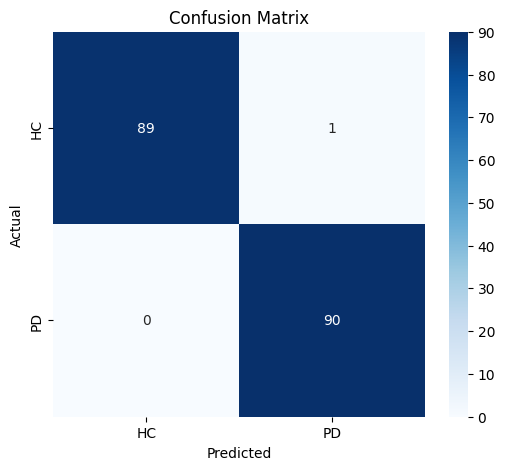

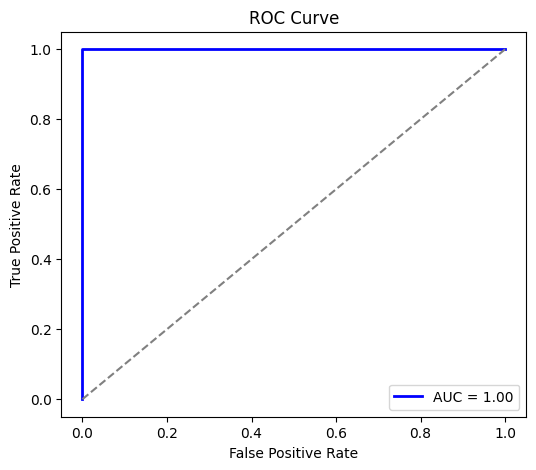

🔥 AUC-ROC Score: 1.0000


In [ ]:

model.eval()

all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        outputs = model(images, tabular_data)
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (outputs > 0.5).float().cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions)
        all_probs.extend(probabilities)
print("🔥 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['HC', 'PD'], digits = 4))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print(f"🔥 AUC-ROC Score: {roc_auc:.4f}")


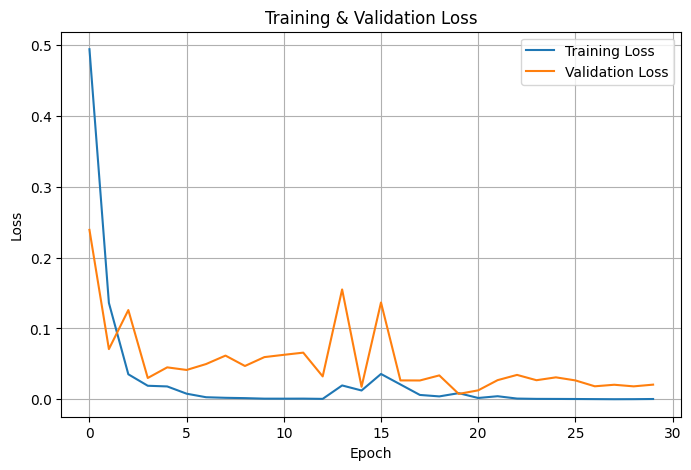

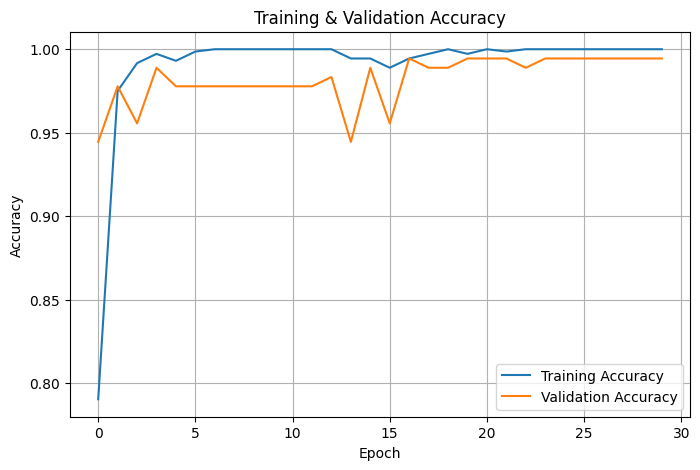

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    return total_params, trainable_params

count_parameters(model)

Total parameters: 7147521
Trainable parameters: 7147521


(7147521, 7147521)

Evaluate Spectrogram-Only Performance

In [ ]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, _, labels in test_loader:  # Only pass spectrogram data
        images = images.to(device)
        tabular_data = torch.zeros((images.size(0), 30)).to(device)  # Pass zero tabular features
        labels = labels.to(device)

        outputs = model(images, tabular_data)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print("🔥 Performance Using Only Spectrograms:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


🔥 Performance Using Only Spectrograms:
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71       100
         1.0       0.00      0.00      0.00        80

    accuracy                           0.56       180
   macro avg       0.28      0.50      0.36       180
weighted avg       0.31      0.56      0.40       180

Accuracy: 0.5555555555555556


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluate Tabular-Only Performance

In [ ]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for _, tabular_data, labels in test_loader:  # Only pass tabular data
        tabular_data = tabular_data.to(device)
        images = torch.zeros((tabular_data.size(0), 3, 224, 224)).to(device)  # Pass blank images
        labels = labels.to(device)

        outputs = model(images, tabular_data)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print("\n🔥 Performance Using Only Tabular Data:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))



🔥 Performance Using Only Tabular Data:
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71       100
         1.0       0.00      0.00      0.00        80

    accuracy                           0.56       180
   macro avg       0.28      0.50      0.36       180
weighted avg       0.31      0.56      0.40       180

Accuracy: 0.5555555555555556


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Tabular data only

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# 🔹 Custom Dataset for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)  # Binary classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 🔹 Extract tabular network from multimodal model
class TabularOnlyModel(nn.Module):
    def __init__(self, num_features):
        super(TabularOnlyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 🔹 Load CSVs
train_df = pd.read_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Tabular/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Datasets/MDVR KCL/Tabular/test2.csv")

# 🔹 Features & Labels
X_train = train_df.drop(columns=["Unnamed: 0", "Class"])
y_train = train_df["Class"]
X_test = test_df.drop(columns=["Unnamed: 0", "Class"])
y_test = test_df["Class"]

# 🔹 Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Feature Selection (increase k to retain more information)
selector = SelectKBest(score_func=mutual_info_classif, k=40)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Replace main datasets
X_train = X_train_selected
X_test = X_test_selected
print("Feature Matrix Shape:", X_train_selected.shape)
print("Feature Matrix Shape:", X_test_selected.shape)

Feature Matrix Shape: (720, 40)
Feature Matrix Shape: (180, 40)


In [ ]:
print(y_train.values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
# Convert to Dataloaders
train_dataset = TabularDataset(X_train, y_train.values)
test_dataset = TabularDataset(X_test, y_test.values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🔹 Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabularOnlyModel(num_features=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 🔹 Training Loop with Validation Accuracy and AUC
for epoch in range(30):
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_preds.extend((outputs.detach().cpu().numpy() > 0.5).astype(int).flatten())
        train_labels.extend(labels.cpu().numpy().flatten())

    train_acc = accuracy_score(train_labels, train_preds)

    # 🔸 Validation Evaluation
    model.eval()
    val_preds = []
    val_probs = []  # ← Store raw probabilities
    val_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            probs = outputs.cpu().numpy()  # ← raw output
            val_probs.extend(probs.flatten())
            val_preds.extend((probs > 0.5).astype(int).flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

    val_acc = accuracy_score(val_labels, val_preds)
    val_auc = roc_auc_score(val_labels, val_probs)

    print(f"Epoch [{epoch+1}/30] | Loss: {running_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

# 🔹 Final Report
print("🔸 Final Accuracy:", accuracy_score(val_labels, val_preds))
print("🔸 Final AUC:", roc_auc_score(val_labels, val_probs))
print("🔸 Classification Report:\n", classification_report(val_labels, val_preds, digits=4))


Epoch [1/30] | Loss: 0.6512 | Train Acc: 0.6472 | Val Acc: 0.6111 | AUC: 0.5700
Epoch [2/30] | Loss: 0.5621 | Train Acc: 0.7417 | Val Acc: 0.5778 | AUC: 0.5716
Epoch [3/30] | Loss: 0.4824 | Train Acc: 0.7847 | Val Acc: 0.6000 | AUC: 0.5783
Epoch [4/30] | Loss: 0.4614 | Train Acc: 0.7792 | Val Acc: 0.5667 | AUC: 0.5351
Epoch [5/30] | Loss: 0.4070 | Train Acc: 0.8139 | Val Acc: 0.5833 | AUC: 0.5375
Epoch [6/30] | Loss: 0.4006 | Train Acc: 0.8236 | Val Acc: 0.5778 | AUC: 0.5343
Epoch [7/30] | Loss: 0.3892 | Train Acc: 0.8292 | Val Acc: 0.5556 | AUC: 0.5200
Epoch [8/30] | Loss: 0.3876 | Train Acc: 0.8125 | Val Acc: 0.5500 | AUC: 0.5442
Epoch [9/30] | Loss: 0.3914 | Train Acc: 0.8236 | Val Acc: 0.5556 | AUC: 0.5562
Epoch [10/30] | Loss: 0.3677 | Train Acc: 0.8250 | Val Acc: 0.5722 | AUC: 0.5528
Epoch [11/30] | Loss: 0.3312 | Train Acc: 0.8500 | Val Acc: 0.5611 | AUC: 0.5385
Epoch [12/30] | Loss: 0.3390 | Train Acc: 0.8431 | Val Acc: 0.5389 | AUC: 0.5426
Epoch [13/30] | Loss: 0.3429 | Train 

In [ ]:
# ✅ Save Model Weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/Ensemble model/Tabular data only/model.pth")
print("✅ Model training completed and saved successfully!")

✅ Model training completed and saved successfully!


In [ ]:

model.eval()

all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        outputs = model(images, tabular_data)
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (outputs > 0.5).float().cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions)
        all_probs.extend(probabilities)
print("🔥 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['HC', 'PD']))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print(f"🔥 AUC-ROC Score: {roc_auc:.4f}")


ValueError: not enough values to unpack (expected 3, got 2)